In [14]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50 

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [15]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
BATCH_SIZE = 32


Num GPUs Available:  1


In [16]:
df = pd.read_csv("data_cleaning/clean_data/image_paths.csv")

## get all unique labels and sort them (for classification_report)
inps = list(df['label'].unique())
inps.sort()
print(inps)
print(df)

# shuffle dataframe
df = df.sample(frac=1)


# stratify ensures that train validate and test sets have approximately the same percentage of samples of each target class as the complete set
# more info here: https://stats.stackexchange.com/questions/250273/benefits-of-stratified-vs-random-sampling-for-generating-training-data-in-classi
# this is good because we have some data that is not evenly represented in the dataset which leads to poor performance if not evenly distributed in training/validating/testing
train,test = train_test_split(df, test_size=0.1, random_state=1,stratify=df['label'])
train,validate = train_test_split(train, test_size=0.111, random_state=1,stratify=train['label']) # 0.25 x 0.8 = 0.2

image_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    horizontal_flip=True,
    rescale= 1.0/255.0,
    rotation_range=30
    )

test_image_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rescale= 1.0/255.0,
    )

train_iterator = image_datagen.flow_from_dataframe(train,x_col="image-path",y_col="label",batch_size=BATCH_SIZE,target_size=(256,256),classes=inps,class_mode="categorical", shuffle=True)

batch_x,batch_y = train_iterator.next()
NUM_CLASSES = batch_y.shape[1]

validate_iterator = image_datagen.flow_from_dataframe(validate,x_col="image-path",y_col="label",batch_size=BATCH_SIZE, target_size=(256,256),classes=inps,class_mode="categorical", shuffle=True)

test_iterator = test_image_datagen.flow_from_dataframe(test,x_col="image-path",y_col="label",batch_size=BATCH_SIZE, target_size=(256,256),classes=inps,class_mode="categorical")

['Acanthus spinosus', 'Achillea millefolium', "Achillea millefolium 'Rosea'", 'Aconitum volubile', 'Actaea racemosa', 'Aesculus parviflora', 'Agastache rugosa', 'Agave havardiana', 'Agave parryi', 'Alcea rosea', 'Alcea rugosa', 'Alchemilla alpina', 'Allium caeruleum', 'Allium cernuum', 'Allium flavum', 'Allium ramosum', 'Allium senescens', 'Allium stellatum', 'Aloe aristata', 'Althaea officinalis', 'Ambrosia psilostachya', 'Amorpha canescens', 'Amorpha fruticosa', 'Anagallis monelli', 'Anaphalis margaritacea', 'Anchusa capensis', 'Andropogon gerardii', 'Andropogon hallii', 'Anemone canadensis', 'Anemone sylvestris', 'Anthemis marschalliana', 'Anthericum ramosum', 'Aquilegia chrysantha', 'Aquilegia elegantula', 'Aquilegia formosa', 'Aquilegia glandulosa', 'Aralia racemosa', 'Arctotis arctotoides', 'Argemone pleiacantha', 'Argemone polyanthemos', 'Aristida purpurea', 'Artemisia frigida', 'Artemisia ludoviciana', 'Artemisia nova', 'Asclepias incarnata', 'Asclepias pumila', 'Asclepias spec

Found 47320 validated image filenames belonging to 329 classes.
Found 5909 validated image filenames belonging to 329 classes.
Found 5915 validated image filenames belonging to 329 classes.


In [17]:
## modified code from https://towardsdatascience.com/3-things-you-need-to-know-before-you-train-test-split-869dfabb7e50
def get_class_counts(df):
    grp = df.groupby(['label']).nunique()

    return grp.to_dict()['image-path']
def get_class_proportions(df):
    class_counts = get_class_counts(df)
    return {val[0]: round(val[1]/df.shape[0],4) for val in class_counts.items()}

print(get_class_counts(test)['Ipomoea leptophylla'])

20


In [18]:
model = ResNet50(include_top=False, input_shape=(256,256,3))

#for layer in model.layers:
    #layer.trainable = False

# mark some layers as not trainable
#model.get_layer('block1_conv1').trainable = False
#model.get_layer('block1_conv2').trainable = False
#model.get_layer('block2_conv1').trainable = False
#model.get_layer('block2_conv2').trainable = False

flat1 = layers.Flatten()(model.output)
class1 = layers.Dense(1024, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.04))(flat1)
layers.Dropout(0.7),
output = layers.Dense(NUM_CLASSES, activation='softmax')(class1)

model = tf.keras.Model(inputs=model.inputs, outputs = output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [19]:
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.0001), metrics=['accuracy'])

In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
fit = model.fit(x=train_iterator,
                steps_per_epoch= len(train_iterator),
                #callbacks=[callback], 
                validation_steps= len(validate_iterator),
                validation_data=validate_iterator,
                verbose=1,
                epochs=50)

Epoch 1/50
1479/1479 [==============================] - 486s 327ms/step - loss: 86.3906 - accuracy: 0.0098 - val_loss: 85.0494 - val_accuracy: 0.0179
Epoch 2/50
1479/1479 [==============================] - 482s 326ms/step - loss: 83.8297 - accuracy: 0.0423 - val_loss: 82.6204 - val_accuracy: 0.0724
Epoch 3/50
1479/1479 [==============================] - 482s 326ms/step - loss: 81.3258 - accuracy: 0.1142 - val_loss: 80.1132 - val_accuracy: 0.1564
Epoch 4/50
1479/1479 [==============================] - 482s 326ms/step - loss: 78.8091 - accuracy: 0.2082 - val_loss: 77.7144 - val_accuracy: 0.2403
Epoch 5/50
1479/1479 [==============================] - 482s 326ms/step - loss: 76.4678 - accuracy: 0.2925 - val_loss: 75.5565 - val_accuracy: 0.2997
Epoch 6/50
1479/1479 [==============================] - 483s 327ms/step - loss: 74.3170 - accuracy: 0.3601 - val_loss: 73.5329 - val_accuracy: 0.3503
Epoch 7/50
1479/1479 [==============================] - 485s 328ms/step - loss: 72.3134 - accuracy: 

In [21]:
# get all test labels from dataframe
y_true = []

# get all true labels
for i in range(len(test_iterator)):
    batch_x,batch_y = test_iterator.next()
    batch_y = list(batch_y)
    y_true += batch_y

#print(y_true)
# get test predictions
y_pred = model.predict(x = test_iterator,
                    steps = len(test_iterator),
                    batch_size=BATCH_SIZE,
                    verbose=1)

# convert one hot to max index
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_true, axis=1)

print(accuracy_score(y_true,y_pred) * 100, "%")

# have to include labels parameter because test set does not have all of the classes from inps
matrix = classification_report(y_true,y_pred,labels=np.arange(len(inps)),target_names =inps)
print('Classification report: \n',matrix)




185/185 [==============================] - 11s 58ms/step
62.417582417582416 %
Classification report: 
                                precision    recall  f1-score   support

            Acanthus spinosus       0.71      0.75      0.73        20
         Achillea millefolium       0.05      0.05      0.05        20
 Achillea millefolium 'Rosea'       0.13      0.15      0.14        20
            Aconitum volubile       0.43      0.45      0.44        20
              Actaea racemosa       0.67      0.60      0.63        20
          Aesculus parviflora       0.50      0.90      0.64        20
             Agastache rugosa       1.00      0.29      0.44         7
             Agave havardiana       0.65      0.55      0.59        20
                 Agave parryi       0.61      0.70      0.65        20
                  Alcea rosea       0.80      0.60      0.69        20
                 Alcea rugosa       0.67      0.60      0.63        20
            Alchemilla alpina       0.56    

In [22]:
model.save('model/')

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('model/') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model/assets


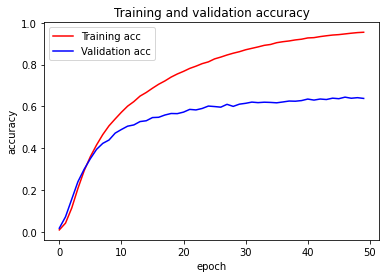

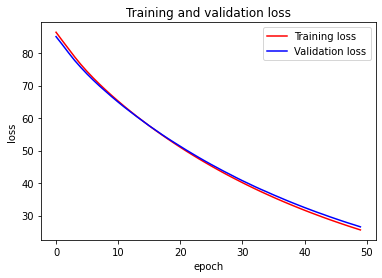

In [23]:
import matplotlib.pyplot as plt 
#Graphing our training and validation
acc = fit.history['accuracy']
val_acc = fit.history['val_accuracy']
loss = fit.history['loss']
val_loss = fit.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

Normalized confusion matrix


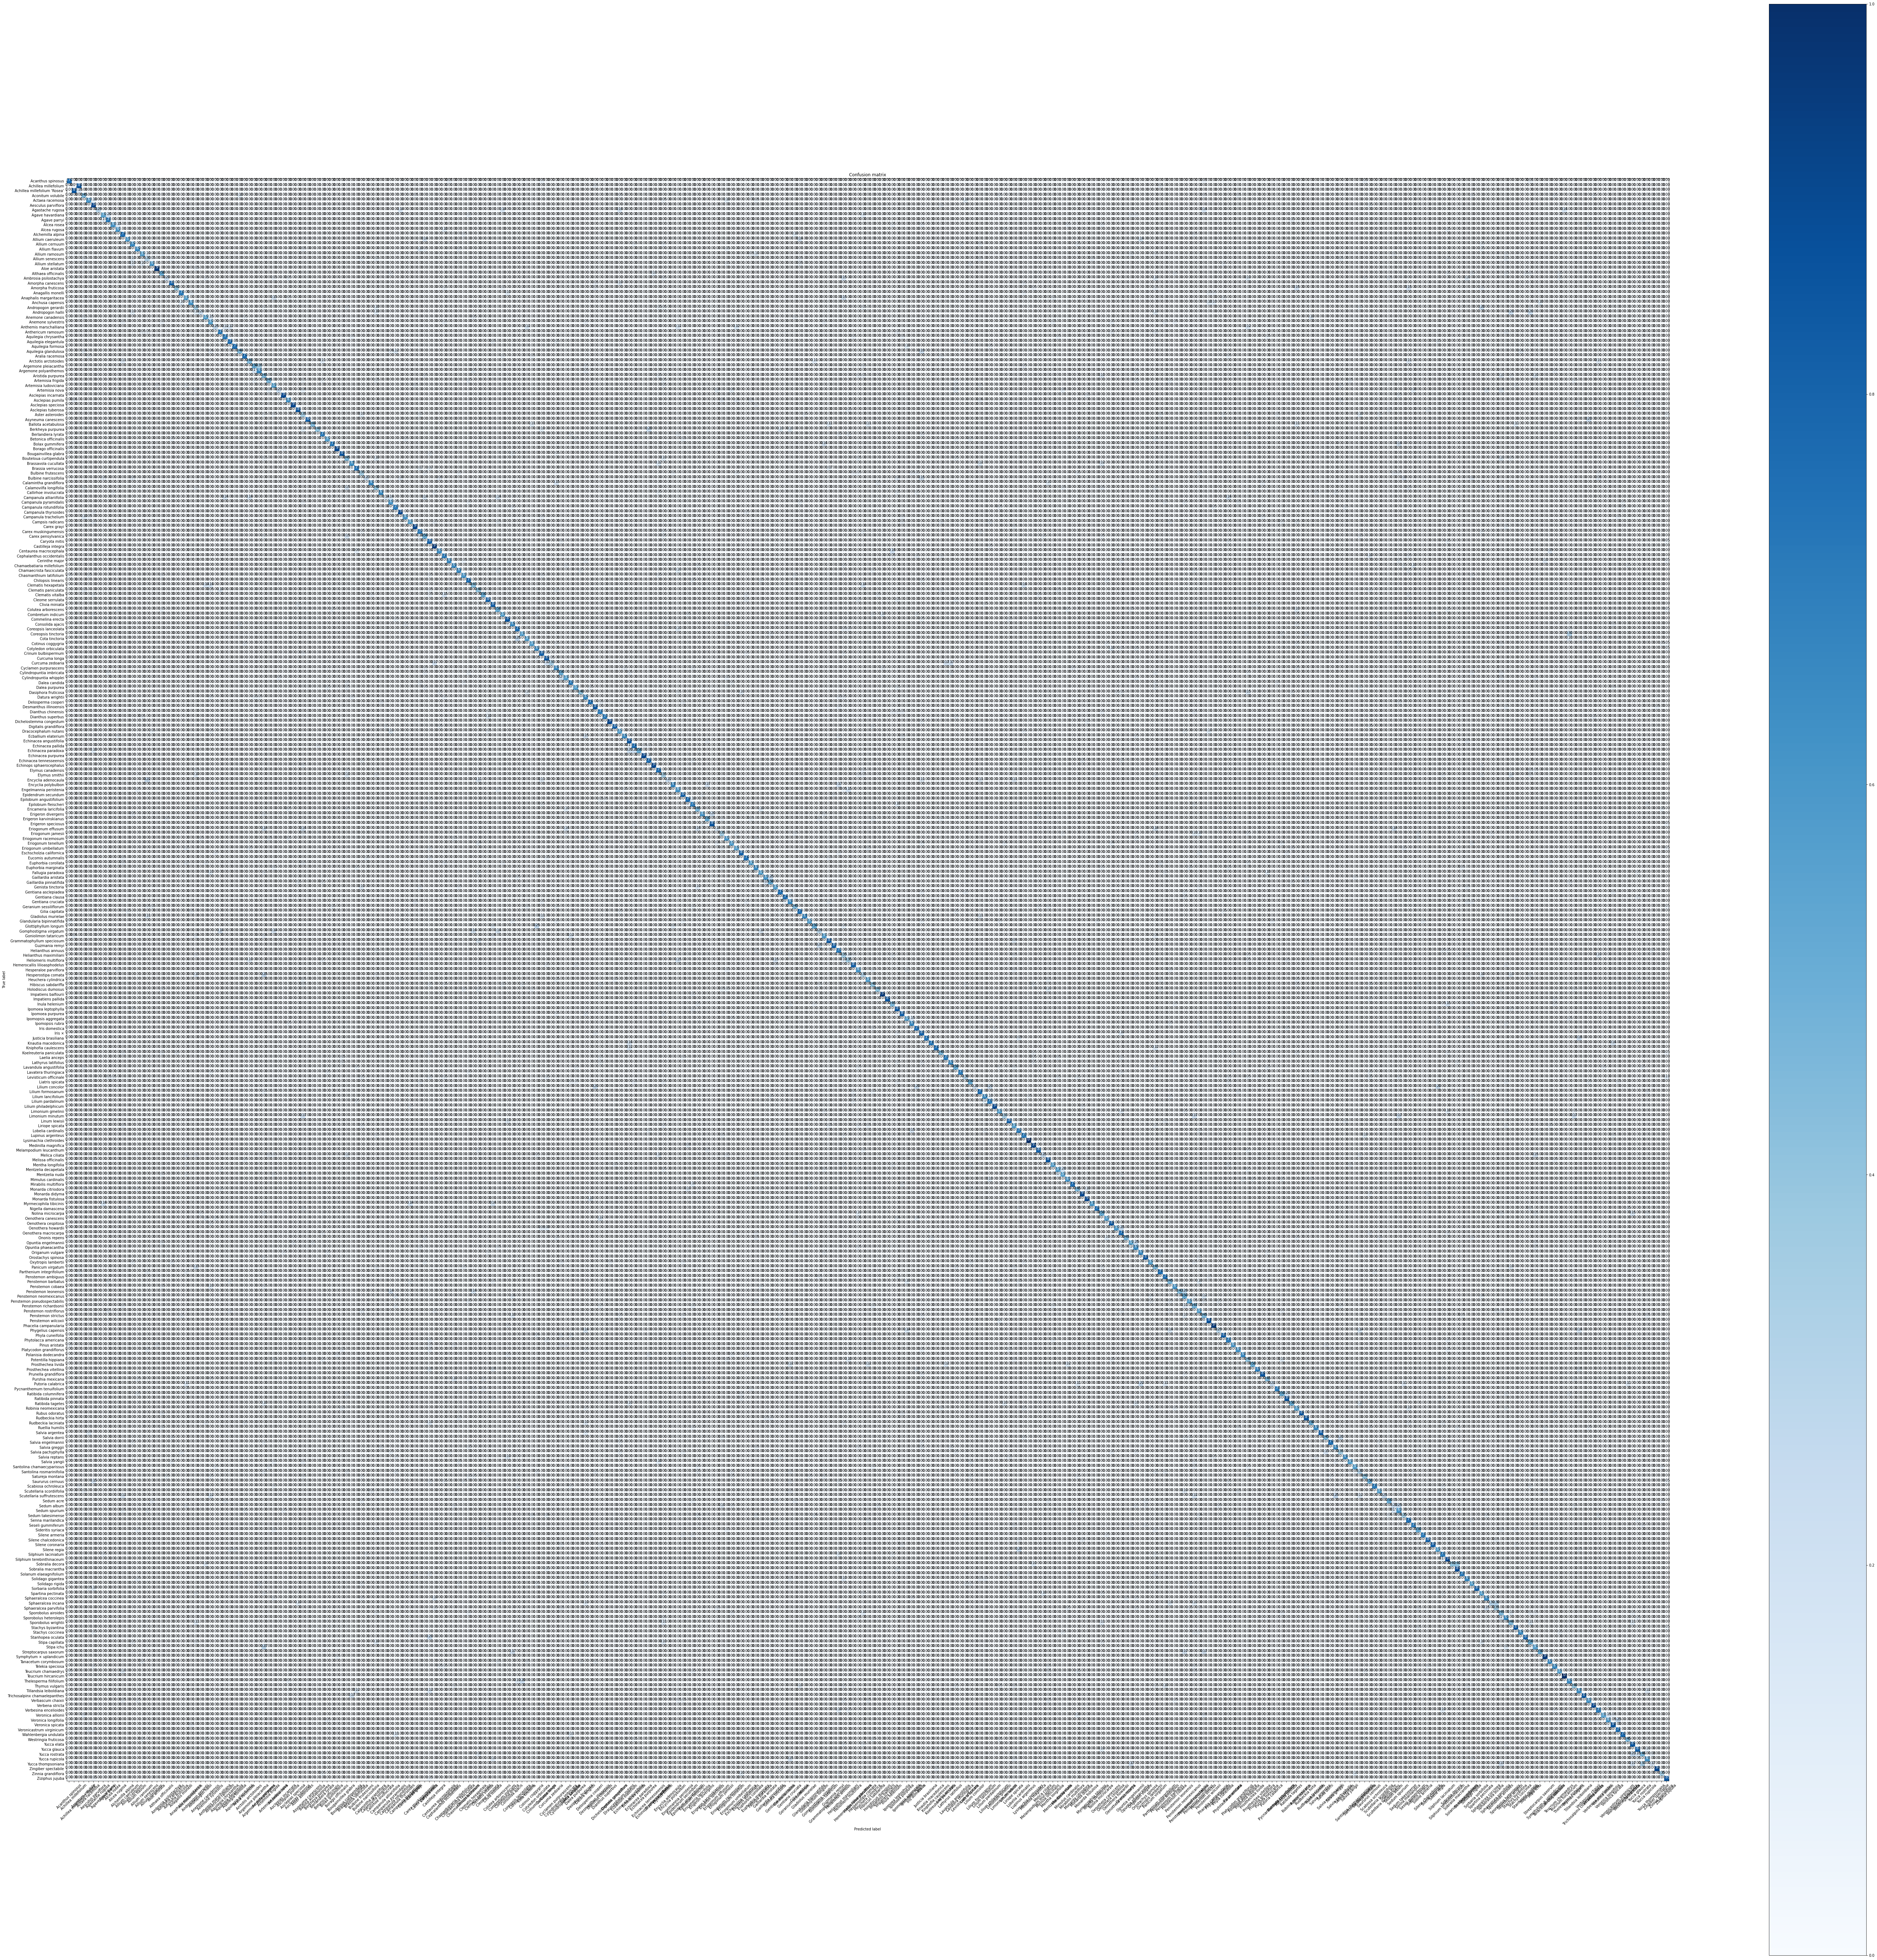

In [24]:
from sklearn.metrics import confusion_matrix
import itertools

# grabbed from here: https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa
confusion_matrix = confusion_matrix(y_true,y_pred)

def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
 
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
 
    # print(cm)
 
    plt.figure(figsize=(100,100))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
       plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

plot_confusion_matrix(confusion_matrix,inps,normalize=True)